In [1]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:100% !important;}
div.cell.code_cell.rendered{width:100%;}
div.input_prompt{padding:0px;}
div.CodeMirror {font-family:Consolas; font-size:20pt;}
div.text_cell_render.rendered_html{font-size:18pt;}
div.text_cell_render.rendered_html{font-size:15pt;}
div.output {font-size:18pt; font-weight:bold;}
div.input {font-family:Consolas; font-size:18pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:120px;}
div.text_cell_render ul li{font-size:18pt;padding:5px;}
table.dataframe{font-size:18px;}
</style>
"""))

**<font size="6" color="red">ch5. LSTM/GRU</font>**
- 5만개 영화 감상평(독립변수) -> 부정/긍정(타겟변수)

## 1. 패키지

In [2]:
import numpy as np
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from time import time #70.1.1부터 현재까지의 밀리세컨

from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score

## 2. 하이퍼 파리미터 설정(이 파라미터를 바꾸면 정확도나 학습 속도에 차이남)

In [3]:
MY_WORDS  = 10000 # imdb 데이터의 단어수
MY_LENGTH = 80    # 영화평 단어수 80개만 독립변수
MY_EMBED  = 32    # Embedding layer의 결과 차원
MY_HIDDEN = 64    # LSTM의 units 차원

MY_EPOCH  = 10    # 학습 수(fit)
MY_BATCH  = 200   # batch_size(fit시 매번 데이터를 가져오는 데이터)

## 3. 데이터 불러오기

In [4]:
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=MY_WORDS)

In [5]:
print('학습셋 입력변수 모양 :', x_train.shape)
print('학습셋 타겟변수 모양 :', y_train.shape)
print('학습셋 샘플 :', type(x_train[2]), x_train[100], y_train[2])
print('테스트셋 변수들 모양 :', x_test.shape, y_test.shape)

학습셋 입력변수 모양 : (25000,)
학습셋 타겟변수 모양 : (25000,)
학습셋 샘플 : <class 'list'> [1, 13, 244, 6, 87, 337, 7, 628, 2219, 5, 28, 285, 15, 240, 93, 23, 288, 549, 18, 1455, 673, 4, 241, 534, 3635, 8448, 20, 38, 54, 13, 258, 46, 44, 14, 13, 1241, 7258, 12, 5, 5, 51, 9, 14, 45, 6, 762, 7, 2, 1309, 328, 5, 428, 2473, 15, 26, 1292, 5, 3939, 6728, 5, 1960, 279, 13, 92, 124, 803, 52, 21, 279, 14, 9, 43, 6, 762, 7, 595, 15, 16, 2, 23, 4, 1071, 467, 4, 403, 7, 628, 2219, 8, 97, 6, 171, 3596, 99, 387, 72, 97, 12, 788, 15, 13, 161, 459, 44, 4, 3939, 1101, 173, 21, 69, 8, 401, 2, 4, 481, 88, 61, 4731, 238, 28, 32, 11, 32, 14, 9, 6, 545, 1332, 766, 5, 203, 73, 28, 43, 77, 317, 11, 4, 2, 953, 270, 17, 6, 3616, 13, 545, 386, 25, 92, 1142, 129, 278, 23, 14, 241, 46, 7, 158] 0
테스트셋 변수들 모양 : (25000,) (25000,)


In [6]:
# 긍정/부정 갯수
print('학습셋의 긍정 갯수 :', y_train.sum())
print('테스트셋의 긍정 갯수 :', y_test.sum())

학습셋의 긍정 갯수 : 12500
테스트셋의 긍정 갯수 : 12500


## 4. 문자단어 -> 정수

In [7]:
word_to_id = imdb.get_word_index() # {'word':id}
print(word_to_id['movie'])
print(word_to_id['film'])
print(word_to_id['sonja'])
print(word_to_id['a'])
print(word_to_id['the'])
# 정수 -> 문자 단어
id_to_word = {} #{1:'the', 3: 'a', 16816:'sonja'}
for word, value in word_to_id.items():
    id_to_word[value] = word
print(id_to_word[1])
print(id_to_word[3])

17
19
16816
3
1
the
a


In [8]:
msg = "What a wonderful movie"
msg = msg.lower().split()
# 1:리뷰시작을 알리는 숫자, 2:문자가짤려서잘못읽어옴, 3:padding처리
data = [1] + [word_to_id.get(m, -1)+3 for m in msg]
print('원 후기 내용 :', msg)
print('encoded된 data :', data)
print('추정된 data :', [id_to_word.get(d-3, '???') for d in data])
print('추정된 data :', ' '.join([id_to_word.get(d-3, '???') for d in data]))

원 후기 내용 : ['what', 'a', 'wonderful', 'movie']
encoded된 data : [1, 51, 6, 389, 20]
추정된 data : ['???', 'what', 'a', 'wonderful', 'movie']
추정된 data : ??? what a wonderful movie


## 5. 숫자영화평 -> 자연어 영화평 return 함수

In [9]:
def decoding(review_num):
    decoded = [id_to_word.get(num-3, '???') for num in review_num]
    return ' '.join(decoded)

In [10]:
print(decoding(x_train[1]), y_train[1])

??? big hair big boobs bad music and a giant safety pin these are the words to best describe this terrible movie i love cheesy horror movies and i've seen hundreds but this had got to be on of the worst ever made the plot is paper thin and ridiculous the acting is an abomination the script is completely laughable the best is the end showdown with the cop and how he worked out who the killer is it's just so damn terribly written the clothes are sickening and funny in equal ??? the hair is big lots of boobs ??? men wear those cut ??? shirts that show off their ??? sickening that men actually wore them and the music is just ??? trash that plays over and over again in almost every scene there is trashy music boobs and ??? taking away bodies and the gym still doesn't close for ??? all joking aside this is a truly bad film whose only charm is to look back on the disaster that was the 80's and have a good old laugh at how bad everything was back then 0


## 6. 영화평 (입력변수)의 길이

In [11]:
def show_length(x_train):
    print('첫 20개 영화평 길이')
    print([len(x_data) for x_data in x_train[:20]])

In [12]:
# pad_sequence 전
show_length(x_train)

첫 20개 영화평 길이
[218, 189, 141, 550, 147, 43, 123, 562, 233, 130, 450, 99, 117, 238, 109, 129, 163, 752, 212, 177]


In [13]:
print('제일 긴 영화평 단어 길이 :', 
     max(len(x_data) for x_data in x_train))
print('제일 짧은 영화평 단어 길이 :', 
     min(len(x_data) for x_data in x_train))
print('영화평 단어 길이 중위수 :',
     np.median([len(x_data) for x_data in x_train]))

제일 긴 영화평 단어 길이 : 2494
제일 짧은 영화평 단어 길이 : 11
영화평 단어 길이 중위수 : 178.0


## 7. 모든 영화평 길이를 동일하게(MY_LENGTH=80)

In [14]:
X_train = pad_sequences(x_train,
                       padding='pre',
                       truncating='pre', # 뒷부분을 짜르고 앞부분을 남김
                       maxlen=MY_LENGTH)
X_test = pad_sequences(x_test,
                      padding='pre',
                      truncating='pre',
                      maxlen=MY_LENGTH)
show_length(X_train), show_length(X_test)

첫 20개 영화평 길이
[80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80]
첫 20개 영화평 길이
[80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80]


(None, None)

## 8. 최종 데이터 shape 확인

In [15]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((25000, 80), (25000,), (25000, 80), (25000,))

In [16]:
print(x_train[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


In [17]:
X_train[0]

array([  15,  256,    4,    2,    7, 3766,    5,  723,   36,   71,   43,
        530,  476,   26,  400,  317,   46,    7,    4,    2, 1029,   13,
        104,   88,    4,  381,   15,  297,   98,   32, 2071,   56,   26,
        141,    6,  194, 7486,   18,    4,  226,   22,   21,  134,  476,
         26,  480,    5,  144,   30, 5535,   18,   51,   36,   28,  224,
         92,   25,  104,    4,  226,   65,   16,   38, 1334,   88,   12,
         16,  283,    5,   16, 4472,  113,  103,   32,   15,   16, 5345,
         19,  178,   32])

## 9. 모델 생성

In [18]:
model = Sequential()
model.add(Embedding(input_dim=MY_WORDS, # 10000
                   output_dim=MY_EMBED, # 32
                   input_length=MY_LENGTH)) # 80
# RNN : 입력 단어의 길이 수가 너무 길면 파리미터 업데이트 안 됨
# 개선모델1. LSTM 개선모델2. GRU
model.add(LSTM(units=MY_HIDDEN,
              input_shape=(MY_LENGTH, MY_EMBED)
         ))
model.add(Dense(units=1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 80, 32)            320000    
                                                                 
 lstm (LSTM)                 (None, 64)                24832     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 344,897
Trainable params: 344,897
Non-trainable params: 0
_________________________________________________________________


## 10. 학습환경 설정 및 학습하기

In [19]:
model.compile(loss='binary_crossentropy', # 이진분류시 손실함수
             optimizer='adam',
             metrics=['acc'])
begin = time() # 70.1.1부터 현재까지의 초수
hist = model.fit(X_train, y_train,
                epochs=MY_EPOCH,
                batch_size=MY_BATCH,
                validation_split=0.2,
                verbose=1)
end = time() # 70.1.1부터 이 시점까지의 초수
print('총 학습시간 :', (end-begin))

Epoch 1/10
100/100 [==============================] - 11s 95ms/step - loss: 0.5465 - acc: 0.7031 - val_loss: 0.4193 - val_acc: 0.8120
Epoch 2/10
100/100 [==============================] - 9s 85ms/step - loss: 0.3186 - acc: 0.8686 - val_loss: 0.3790 - val_acc: 0.8328
Epoch 3/10
100/100 [==============================] - 8s 84ms/step - loss: 0.2420 - acc: 0.9071 - val_loss: 0.3675 - val_acc: 0.8374
Epoch 4/10
100/100 [==============================] - 8s 85ms/step - loss: 0.1966 - acc: 0.9276 - val_loss: 0.3970 - val_acc: 0.8268
Epoch 5/10
100/100 [==============================] - 9s 85ms/step - loss: 0.1620 - acc: 0.9427 - val_loss: 0.5261 - val_acc: 0.8130
Epoch 6/10
100/100 [==============================] - 9s 85ms/step - loss: 0.1361 - acc: 0.9530 - val_loss: 0.4761 - val_acc: 0.8128
Epoch 7/10
100/100 [==============================] - 9s 85ms/step - loss: 0.1114 - acc: 0.9633 - val_loss: 0.5673 - val_acc: 0.8160
Epoch 8/10
100/100 [==============================] - 9s 85ms/step -

In [20]:
hist.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

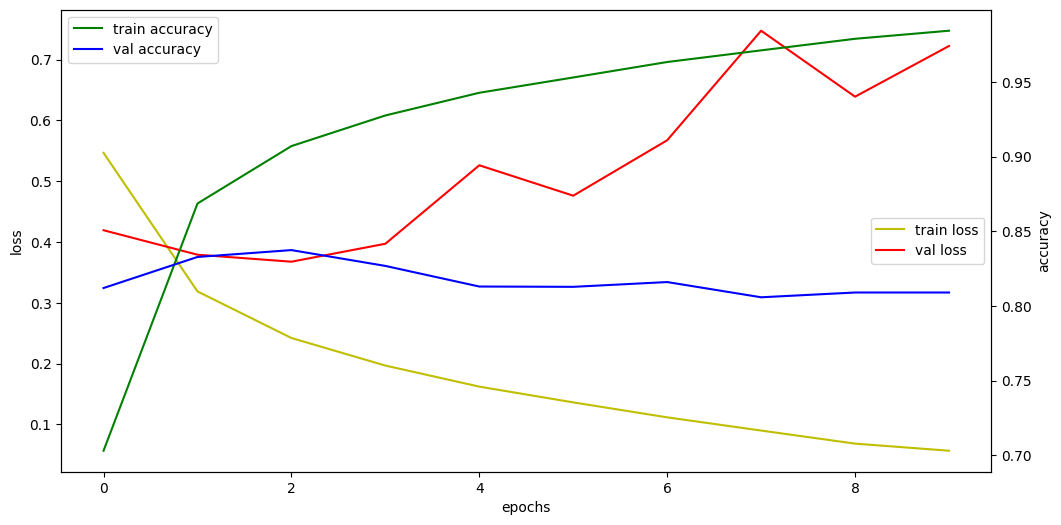

In [21]:
# 5. 모델 학습과정 시각화
import matplotlib.pyplot as plt
fig, loss_ax = plt.subplots(figsize=(12,6))
loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
acc_ax = loss_ax.twinx()
acc_ax.plot(hist.history['acc'], 'g', label='train accuracy')
acc_ax.plot(hist.history['val_acc'], 'b', label='val accuracy')
loss_ax.set_xlabel('epochs')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(loc='center right')
acc_ax.legend(loc='upper left')
plt.show()

## 11. 모델 평가

In [22]:
# pad_sequences 'post' : 75.81%
# pad_sequences 'pre' : 80.19%
loss, acc = model.evaluate(X_test, y_test)
print('정확도 :', acc)

782/782 [==============================] - 8s 10ms/step - loss: 0.7465 - acc: 0.8007
정확도 : 0.8007199764251709


In [23]:
X_test

array([[   0,    0,    0, ...,   14,    6,  717],
       [1669,  398,  229, ...,  125,    4, 3077],
       [ 687,    2,  203, ...,    9,   57,  975],
       ...,
       [   0,    0,    0, ...,   21,  846, 5518],
       [   8,   97,   14, ..., 2302,    7,  470],
       [ 718,    2,    9, ...,   34, 2005, 2643]])